In [55]:
import pandas as pd
import pickle
import warnings; warnings.filterwarnings('ignore')
import sklearn.preprocessing as preprocessing
import matplotlib.pyplot as plt
from sklearn import linear_model

## Unpickling `test`

In [21]:
test = pd.read_pickle('../data/test.p')

### One-Hot Encoding Necessary for LASSO

In [3]:
train_df = pd.read_pickle('../data/train_df.p')
X = pickle.load(open('../data/X.p', 'rb'))
y = train_df.SalePrice

In [54]:
X_dummies = pd.get_dummies(X)

### Scaling Necessary for LASSO

##### Why Scale Dummy Variables
There is a lot of disagreement at least on StackOverflow. We will take the recommendation of the man who literally wrote the book on LASSO and regularization, Tibshirani [THE LASSO METHOD FOR VARIABLE SELECTION IN THE COX MODEL, Statistics in Medicine, VOL. 16, 385-395 (1997)](http://statweb.stanford.edu/~tibs/lasso/fulltext.pdf)

> The lasso method requires initial standardization of the regressors, so that the penalization scheme is fair to all regressors. For categorical regressors, one codes the regressor with dummy variables and then standardizes the dummy variables. As pointed out by a referee, however, the relative scaling between continuous and categorical variables in this scheme can be somewhat arbitrary.

In [6]:
def standard_scale_train(dataframe):
    array_ = preprocessing.scale(dataframe.values)
    if isinstance(dataframe, pd.DataFrame):
        scaled_df = pd.DataFrame(array_, 
                                 index = dataframe.index,
                                 columns = dataframe.columns)
    elif isinstance(dataframe, pd.Series):
        scaled_df = pd.Series(array_,
                              index = dataframe.index)
    
    return scaled_df

In [7]:
X_scaled = standard_scale_train(X_dummies)

0.9434107172967149


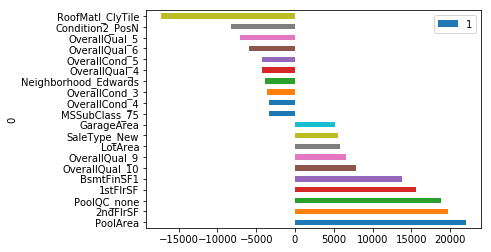

In [27]:
lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(X_scaled, y)
print(lasso.score(X_scaled,y))

def plot_coef(model, top_n = 10):
    '''
    Plots the magnitude of coefficients
    '''
    cols = X_scaled.columns
    coef = model.coef_
    zipped = list(zip(cols, coef))
    zipped.sort(key=lambda x: x[1], reverse = True)
    top_10 = pd.DataFrame(zipped).head(top_n)
    bottom_10 = pd.DataFrame(zipped).tail(top_n)
    return pd.concat([top_10, bottom_10], axis=0).plot.barh(x = 0, y = 1)

plot_coef(lasso)

#### Scaling Test Set

In [53]:
def standard_scale_test(test, X):
    X_std = X.std()
    X_mean = X.mean()
    
    for c in test.columns:
        if X_std[c] > 0:
            test[c] = test[c].apply(lambda x: (x-X_mean[c])/X_std[c])
    test_scaled = test
    return test_scaled

test_scaled = standard_scale_test(test_dummies, X_dummies)

In [22]:
def get_test_dummies(test_df, X_dummies):
    test_dummies = pd.get_dummies(data = test_df)
    
    # There may be values for categorical features in the training set and not in the test set.      
    values_not_in_test_dummies = set(X_dummies.columns) - set(test_dummies.columns)
    for v in values_not_in_test_dummies:
        test_dummies[v] = 0
    test_dummies.shape
    # Values not in the training set, but are in the test set. 
    # Eg The range of GarageCars in the training set is [1,4];
    # The test set may have a house with more than four cars
    values_not_in_X = set(test_dummies.columns) - set(X_dummies.columns)
    test_dummies = test_dummies.drop(columns = list(values_not_in_X))
    
    col_order = X_dummies.columns.tolist()
    test_dummies = test_dummies[col_order]
    
    return test_dummies
    
test_dummies = get_test_dummies(test, X_dummies)

In [28]:
test_scaled = test_scaled[X_scaled.columns.tolist()]

In [29]:
submission = pd.DataFrame({'SalePrice': lasso.predict(test_scaled)},
                         index = test.index)
submission.to_csv('ames-submission-3.csv')

### Kaggle Score
Kaggle uses the *root mean square log error* for this competition.
![Kaggle Score](../doc/kaggle-scr-2018-dec-19.PNG)

![rmsle](https://image.slidesharecdn.com/rmslecostfunction-160623032122/95/rmsle-cost-function-9-638.jpg?cb=1466652265)

In [ ]:
my_scr = 0.19433

## Testing LASSO Using Pipelines Coming Soon